In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt

# Importing NumPy (Numerical Python) which is a library consisting of multidimensional array objects and a collection of routines for processing those arrays. It also gives an alias to the library.
import numpy as np

% matplotlib inline
np.random.seed(2017) 

# There are two main types of models available in Keras: the Sequential model and the Model class used with the functional API.
# Sequential model is a linear stack of layers. Importing Sequential model from Keras.
from keras.models import Sequential, Model

# Importing different layers from Keras.
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Lambda, Concatenate
from keras.layers.normalization import BatchNormalization

# Importing the utils library of Keras.
from keras.utils import np_utils

# Importing the concatenate library of Keras
from keras.layers.merge import concatenate

import tensorflow as tf

# Importing the callbacks of Keras.
from keras.callbacks import ModelCheckpoint

In [2]:
# CIFAR10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Importing CIFAR10 dataset from Keras.
from keras.datasets import cifar10

# Loading the CIFAR10 60000 Training and 10000 Test data into respective numpy arrays
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

# Setting the count, number of channels, rows and columns of training images
num_train, img_channels, img_rows, img_cols =  train_features.shape

# Setting the count of test images
num_test, _, _, _ =  test_features.shape

# Setting number of classes (10)
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 26s 0us/step


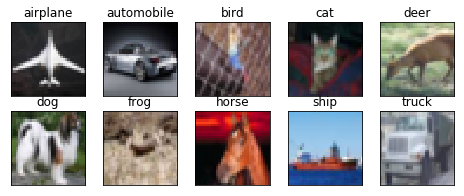

In [3]:
# Setting up the class names
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# Plotting an image from each of the 10 classes
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# Custom function to test accuracy
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Pixel normalization for training images
train_features = train_features.astype('float32')/255

# Pixel normalization for test images
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
# Space_to_depth funcction of Tensorflow rearranges blocks of spatial data into depth. 
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [17]:
# Define the model
input = Input(shape=(32, 32, 3))
block1 = Convolution2D(32, 3, 3, border_mode='same')(input) #32,32; 3
block1 = BatchNormalization()(block1)
block1 = Activation('relu')(block1)

block2 = Dropout(0.125)(block1)
block2 = BatchNormalization()(block2)
block2 = Convolution2D(48, 3, 1, border_mode='same',)(block2) #32,32; 5
block2 = Convolution2D(48, 1, 3, border_mode='same',)(block2) #32,32; 5
block2 = Activation('relu')(block2)

block3 = Convolution2D(32, 1, 1)(block2) #32,32; 5
block3 = MaxPooling2D(pool_size=(2, 2))(block3) #16,16; 10

block4 = Dropout(0.125)(block3)
block4 = BatchNormalization()(block4)
block4 = SeparableConv2D(48, 3, 3, border_mode='same')(block4) #16,16; 14 (separableconv2d increase RF by 4 and not 2.)
block4 = Activation('relu')(block4)
skip_connection = block4 #16,16

block5 = Dropout(0.125)(block4)
block5 = BatchNormalization()(block5)
block5 = Convolution2D(96, 3, 3, border_mode='same',)(block5) #16,16; 16
block5 = Activation('relu')(block5)
skip_connection2 = block5 #16,16

block6 = Convolution2D(32, 1, 1)(block5) #16,16; 16
block6 = MaxPooling2D(pool_size=(2, 2))(block6) #8,8; 32

block7 = Dropout(0.125)(block5)
block7 = BatchNormalization()(block6)
block7 = Convolution2D(48, 5, 5, border_mode='same')(block6) #8,8; 36
block7 = Activation('relu')(block6)

skip_connection = Convolution2D(32, 1, 1)(skip_connection) #16,16
skip_connection = BatchNormalization()(skip_connection)
skip_connection = Activation('relu')(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection) #8,8

block8 = concatenate([skip_connection, block7]) #8,8

block9 = Dropout(0.125)(block8)
block9 = BatchNormalization()(block9)
block9 = Convolution2D(96, 3, 3, border_mode='same', dilation_rate=(2, 2))(block9) #8,8; 40 (dilation 2 increases RF by 4 and not 2.)
block9 = Activation('relu')(block9)

skip_connection2 = Convolution2D(32, 1, 1)(skip_connection2) #16,16
skip_connection2 = BatchNormalization()(skip_connection2)
skip_connection2 = Activation('relu')(skip_connection2)
skip_connection2 = Lambda(space_to_depth_x2)(skip_connection2) #8,8

block10 = concatenate([skip_connection2, block9]) #8,8

block11 = Convolution2D(10, 1, 1)(block10) #8,8; 40
block11 = Convolution2D(10, 8, 8)(block11) #1,1; 40

output = Flatten()(block11)
output = Activation('softmax')(output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 1), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(48, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (

In [21]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 32, 32, 32)   128         conv2d_27[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 32, 32, 32)   0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
dropout_14

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Mounting the Google Drive to save the weights
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Specifying the path to store the weights
filepath="/content/gdrive/My Drive/Assignment6B:{epoch:03d}-acc:{acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

Epoch 1/50
  3/390 [..............................] - ETA: 18s - loss: 1.4374 - acc: 0.4974

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  del sys.path[0]


390/390 [==============================] - 14s 35ms/step - loss: 1.1858 - acc: 0.5758 - val_loss: 1.2172 - val_acc: 0.5792

Epoch 00001: acc improved from -inf to 0.57582, saving model to /content/gdrive/My Drive/Assignment6B:001-acc:0.576.hdf5
Epoch 2/50
390/390 [==============================] - 14s 36ms/step - loss: 0.9257 - acc: 0.6768 - val_loss: 1.0057 - val_acc: 0.6493

Epoch 00002: acc improved from 0.57582 to 0.67689, saving model to /content/gdrive/My Drive/Assignment6B:002-acc:0.677.hdf5
Epoch 3/50
390/390 [==============================] - 14s 35ms/step - loss: 0.7755 - acc: 0.7259 - val_loss: 0.8707 - val_acc: 0.6932

Epoch 00003: acc improved from 0.67689 to 0.72596, saving model to /content/gdrive/My Drive/Assignment6B:003-acc:0.726.hdf5
Epoch 4/50
390/390 [==============================] - 14s 35ms/step - loss: 0.6869 - acc: 0.7576 - val_loss: 1.0285 - val_acc: 0.6522

Epoch 00004: acc improved from 0.72596 to 0.75764, saving model to /content/gdrive/My Drive/Assignment

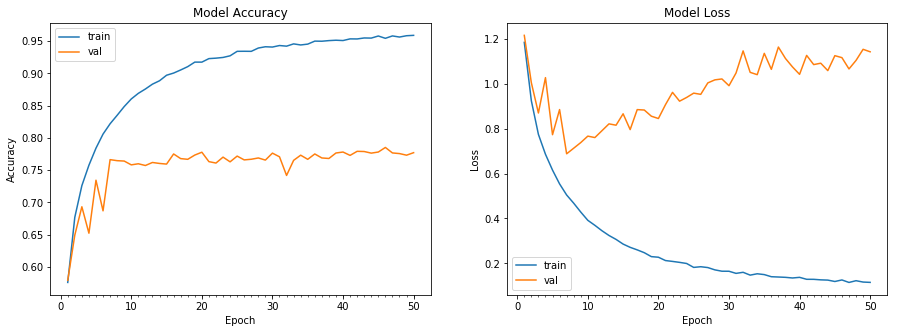

Accuracy on test data is: 77.71


In [26]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks=[checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

# BEST ACCURACY WITH DIFFERENT CONVOLUTION LAYERS

Epoch 50/50
390/390 [==============================] - 14s 35ms/step - loss: 0.1149 - **acc: 0.9591** - val_loss: 1.1438 - val_acc: 0.7771

Epoch 00050: acc improved from **0.95849 to 0.95908**, saving model to /content/gdrive/My Drive/Assignment6B:050-acc:0.959.hdf5